# Healthcare fraud model

### Importing libraries

In [101]:
#import lightgbm as lg

import xgboost as xgb

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder

from collections import OrderedDict, defaultdict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_recall_curve, average_precision_score

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import pickle

### Loading data and intial data exploration

In [2]:
data = pd.read_csv('ABC-Claims.csv' )

In [3]:
print(data.shape)
data.head()

(1628, 17)


,PROVIDER_ID,PROVIDER_NAME,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,DATE_OF_SERVICE,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,RECORD_ID,Fraud,Fraud Type
0,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,77859,11/12/2012,2,3,8,"$1,362.00",F952,20205,9999999998,1.201020e+11,Yes,Upcoding
1,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,78753,10/13/2012,7,4,7,"$1,816.00",F952,20103,9999999998,1.201020e+11,Yes,Unbundling
2,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,M,78751,12/1/2012,7,77,4,"$34,958.00",F952,20200,9999999998,1.201020e+11,Yes,Unbundling
3,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,76543,12/1/2012,7,4,8,"$1,816.00",F329,24300,9999999998,1.201020e+11,Yes,Unbundling
4,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,77378,12/1/2012,7,5,10,"$2,270.00",F329,22551,9999999998,1.201020e+11,Yes,Upcoding


In [4]:
data.dtypes

PROVIDER_ID                 int64
PROVIDER_NAME              object
PROV_INDICATOR             object
ADMISSION_TYPE             object
SEX_CODE                   object
PAT_ZIP                     int64
DATE_OF_SERVICE            object
ADMIT_WEEKDAY               int64
LENGTH_OF_STAY              int64
PAT_AGE                     int64
TOTAL_CHARGES              object
DIAGNOSIS_CODE             object
PROC_CODE                   int64
ATTENDING_PHYS_UNIF_ID      int64
RECORD_ID                 float64
Fraud                      object
Fraud Type                 object
dtype: object

In [5]:
for col in data.columns:
    print(col, data[col].nunique(), data[col].dtype)

PROVIDER_ID 9 int64
PROVIDER_NAME 9 object
PROV_INDICATOR 4 object
ADMISSION_TYPE 4 object
SEX_CODE 2 object
PAT_ZIP 374 int64
DATE_OF_SERVICE 11 object
ADMIT_WEEKDAY 5 int64
LENGTH_OF_STAY 101 int64
PAT_AGE 22 int64
TOTAL_CHARGES 1324 object
DIAGNOSIS_CODE 73 object
PROC_CODE 139 int64
ATTENDING_PHYS_UNIF_ID 79 int64
RECORD_ID 2 float64
Fraud 2 object
Fraud Type 6 object


In [6]:
data.describe()

,PROVIDER_ID,PAT_ZIP,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,RECORD_ID
count,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1628.000000,1.628000e+03,1.628000e+03
mean,22131.972359,75108.560811,6.286241,14.363636,11.267199,10032.619779,7.622705e+09,1.219447e+11
std,15941.879910,12953.949848,0.622569,68.265213,6.114799,13085.131089,3.392175e+09,2.344650e+10
min,100.000000,691.000000,2.000000,1.000000,0.000000,114.000000,1.018542e+09,1.201020e+11
25%,101.000000,75948.000000,6.000000,2.000000,7.000000,1830.000000,5.054166e+09,1.201020e+11
50%,26000.000000,76541.000000,6.000000,4.000000,12.000000,3951.000000,1.000000e+10,1.201020e+11
75%,38001.000000,79201.000000,7.000000,9.000000,16.000000,20103.000000,1.000000e+10,1.201020e+11
max,58000.000000,88888.000000,7.000000,1574.000000,21.000000,95956.000000,1.000000e+10,4.200940e+11


In [7]:
for col in data.columns:
    if data[col].dtype == 'O':
#         print(col)
        print(col, data[col].unique(), '\n')

PROVIDER_NAME ['Austin State Hospital' 'Big Spring State Hospital'
 'Baptist St Anthonys Ambulatory Care' 'Childress Regional Medical Center'
 'Baylor Medical Center-Garland' 'Allegiance Specialty Clinics'
 'CHRISTUS Jasper Memorial Hospital' 'Baylor Medical Center at Carrollton'
 'Brownwood Regional Medical Center'] 

PROV_INDICATOR ['Facility' 'Ambulatory Care' 'Emergancy Care' 'Professional'] 

ADMISSION_TYPE ['ELECTIVE ADMISSION' 'NEWBORN' 'URGENT' 'Emergency'] 

SEX_CODE ['F' 'M'] 

DATE_OF_SERVICE ['11/12/2012' '10/13/2012' '12/1/2012' '1/12/2013' '9/5/2013' '9/25/2013'
 '8/21/2013' '7/11/2014' '7/12/2013' '7/13/2013' '7/11/2013'] 

TOTAL_CHARGES ['$1,362.00 ' '$1,816.00 ' '$34,958.00 ' ... '$19,873.74 ' '$21,380.39 '
 '$13,341.16 '] 

DIAGNOSIS_CODE ['F952' 'F329' 'F4321' 'F341' 'F42' 'F0630' 'F060' 'F259' 'F29' 'F3160'
 'F200' 'F315' 'F319' 'J70' 'F209' 'J68' 'M542' 'H9072' 'J9690' 'S06360A'
 'R112' 'I629' 'C719' 'D432' 'D434' 'T85192A' 'C717' 'I6529' 'I498'
 'S14105A' 'G309' '

In [93]:
df= data.copy(deep = True)

## Transforming the continous variables and date

In [94]:
df.dtypes

PROVIDER_ID                 int64
PROVIDER_NAME              object
PROV_INDICATOR             object
ADMISSION_TYPE             object
SEX_CODE                   object
PAT_ZIP                     int64
DATE_OF_SERVICE            object
ADMIT_WEEKDAY               int64
LENGTH_OF_STAY              int64
PAT_AGE                     int64
TOTAL_CHARGES              object
DIAGNOSIS_CODE             object
PROC_CODE                   int64
ATTENDING_PHYS_UNIF_ID      int64
RECORD_ID                 float64
Fraud                      object
Fraud Type                 object
dtype: object

In [95]:
# Date of service
df['DATE_OF_SERVICE'] = pd.to_datetime(df['DATE_OF_SERVICE'])

In [96]:
df['day_of_year'] = df['DATE_OF_SERVICE'].dt.dayofyear
df['month'] = df['DATE_OF_SERVICE'].dt.month

In [97]:
# Charges
df['TOTAL_CHARGES'] = df['TOTAL_CHARGES'].str.strip().str.slice(start = 1).str.replace(',','').astype(float)

In [98]:
#df['PAT_ZIP'] = df['PAT_ZIP'].astype('category')

### Transforming the categorical columns

In [99]:
df['Fraud'] = np.where(df['Fraud']== 'Yes',1,0)

In [104]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
cat_cols.remove('Fraud Type')
cat_cols.remove('PROVIDER_NAME')
cat_cols

['PROV_INDICATOR', 'ADMISSION_TYPE', 'SEX_CODE', 'DIAGNOSIS_CODE']

In [140]:
%%time
column_map = {}
for col in cat_cols:
    column_map[col] = {v:i for i,v in enumerate(data[col].unique())}
    df[col] = df[col].map(column_map[col])

Wall time: 7.94 ms


In [141]:
with open('column_map_FAA.pk', 'wb') as f:
    pickle.dump(column_map,f)

In [16]:
df2 = data.copy(deep = True)

In [17]:
%%time
for col in cat_cols:
    df2[col] = LabelEncoder().fit_transform(df2[col])

2.73 ms ± 339 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
df.head()

,PROVIDER_ID,PROVIDER_NAME,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,DATE_OF_SERVICE,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,RECORD_ID,Fraud,Fraud Type,day_of_year,month
0,100,0,0,0,0,77859,2012-11-12,2,3,8,1362.0,0,20205,9999999998,1.201020e+11,1,Upcoding,317,11
1,100,0,0,0,0,78753,2012-10-13,7,4,7,1816.0,0,20103,9999999998,1.201020e+11,1,Unbundling,287,10
2,100,0,0,0,1,78751,2012-12-01,7,77,4,34958.0,0,20200,9999999998,1.201020e+11,1,Unbundling,336,12
3,100,0,0,0,0,76543,2012-12-01,7,4,8,1816.0,1,24300,9999999998,1.201020e+11,1,Unbundling,336,12
4,100,0,0,0,0,77378,2012-12-01,7,5,10,2270.0,1,22551,9999999998,1.201020e+11,1,Upcoding,336,12


## Modeling for Fraud event

In [19]:
data.groupby(['PROVIDER_ID','PROVIDER_NAME'])['PROVIDER_ID','PROVIDER_NAME'].size()

PROVIDER_ID  PROVIDER_NAME                      
100          Austin State Hospital                  225
101          Big Spring State Hospital              206
1000         Baptist St Anthonys Ambulatory Care     90
26000        Childress Regional Medical Center      361
27000        Baylor Medical Center-Garland          144
31001        Allegiance Specialty Clinics           103
38001        CHRISTUS Jasper Memorial Hospital      442
42000        Baylor Medical Center at Carrollton     42
58000        Brownwood Regional Medical Center       15
dtype: int64

In [404]:
data['ATTENDING_PHYS_UNIF_ID'].unique()

array([9999999998, 7391718227, 7525872385, 5684395927, 4834819126,
       3741741693, 1398066168, 3277659959, 4875303262, 1285148555,
       9684125817, 2016530466, 7965066904, 1095950395, 7584788626,
       3922810251, 6953843528, 5303212507, 7816323212, 3632561096,
       7255358970, 1250402230, 7520373535, 6387432529, 1195629471,
       3591791558, 3576707590, 1882851470, 1812387061, 1142327648,
       4499097258, 1201976484, 1553432173, 2138976401, 1096548130,
       8614349252, 4363818327, 1661194015, 5147834567, 1366074485,
       4141418103, 1742549518, 1633203723, 4692587262, 1839482590,
       4899181384, 9856527494, 1719408906, 9034328580, 1300683632,
       4012323272, 8354884154, 2096141171, 7189894303, 8461698228,
       1023900518, 1477690187, 8780307609, 1122520641, 5054165596,
       6163274563, 6050567890, 5800518775, 4477855766, 1135172036,
       4169008553, 7436781672, 3896381094, 1545418303, 1018541937,
       1903320846, 9456593883, 1309078565, 8274783216, 8592445

In [108]:
df_fraud = df.drop(columns = ['Fraud Type', 'DATE_OF_SERVICE', 'RECORD_ID','PROVIDER_NAME']).copy(deep = True)

In [109]:
df_x = df_fraud.drop('Fraud', axis = 1)
df_y = df_fraud['Fraud'].values

X_train, X_test,y_train, y_test = train_test_split(df_x, df_y, test_size = 0.15, random_state = 123) 

train_data = xgb.DMatrix(X_train, label = y_train)
test_data = xgb.DMatrix(X_test, label = y_test)

In [110]:
sum(df_fraud.Fraud == 1), sum(df_fraud.Fraud == 0), sum(df_fraud.Fraud == 1)/len(df_fraud), sum(df_fraud.Fraud == 0)/sum(df_fraud.Fraud == 1)

(1412, 216, 0.8673218673218673, 0.1529745042492918)

In [111]:
np.mean(df_fraud.Fraud == 1)

0.8673218673218673

In [112]:
# Defining parameters
scale_pos_weight = sum(df_fraud.Fraud == False)/sum(df_fraud.Fraud == True)

params = {
    'objective': 'binary:logistic',
    'learning_rate': 0.01,
    'max_depth': 6,
    'silent': 1,
    'subsample': 0.9,
    'eval_metric': ['error','auc'],
    'colsample_bytee': 0.8
    #'scale_pos_weight' : scale_pos_weight
    #'base_score':np.mean(df.Class == 1)
    }

num_round = 100
watchlist = [(test_data, 'eval'), (train_data, 'train')]

In [113]:
%%time
model_xgb = xgb.train(params, train_data, num_boost_round = num_round,
                     evals = watchlist, verbose_eval = 50,
                     early_stopping_rounds = 100,
                     maximize = True)

[0]	eval-error:0.085714	eval-auc:0.918818	train-error:0.077368	train-auc:0.938653
Multiple eval metrics have been passed: 'train-auc' will be used for early stopping.

Will train until train-auc hasn't improved in 100 rounds.
[50]	eval-error:0.053061	eval-auc:0.965182	train-error:0.059291	train-auc:0.976655
[99]	eval-error:0.04898	eval-auc:0.976909	train-error:0.045553	train-auc:0.984118
Wall time: 206 ms


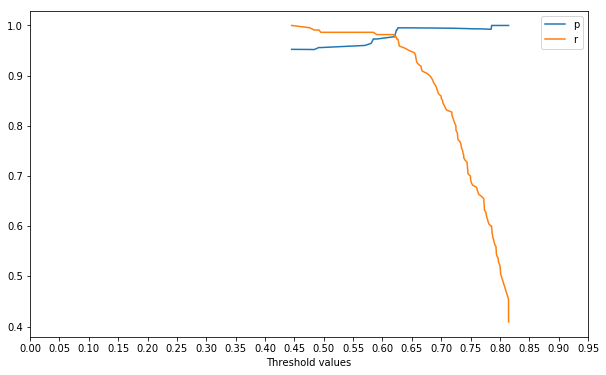

In [114]:
p,r,a = precision_recall_curve(y_test,model_xgb.predict(test_data) )
len(p), len(p[:-1])
plt.figure(figsize=(10,6))
plt.plot(a, p[:-1])
plt.plot(a, r[:-1])
plt.legend('pr')
plt.xlabel('Threshold values')
plt.xticks(np.arange(0,1,0.05))
plt.show()

In [115]:
pred = np.where(model_xgb.predict(test_data) >= 0.6, 1,0)
print(sum(y_test == 1),sum(pred== 1))
print(sum(y_test == 0),sum(pred== 0))

220 221
25 24


In [116]:
type(y_test), type(pred)

(numpy.ndarray, numpy.ndarray)

In [117]:
sum(y_test == pred), sum(y_test != pred), sum((y_test == 1) & (pred == 1)), sum((y_test == 0) & (pred == 0)), sum((y_test == 1) & (pred == 0)), sum((y_test == 0) & (pred == 1)),

(236, 9, 216, 20, 4, 5)

In [118]:
type((y_test == 0))

numpy.ndarray

In [119]:
accuracy_score(y_test, pred), f1_score(y_test, pred)

(0.963265306122449, 0.9795918367346939)

In [120]:
cm = confusion_matrix(y_test,pred)
print(cm)

[[ 20   5]
 [  4 216]]


In [121]:
tn, fp, fn, tp = confusion_matrix(y_test,pred).ravel()
cm = np.array([tp,fp,fn,tn]).reshape(2,2)

[Text(0, 0.5, 'Fraud'), Text(0, 1.5, 'Not-fraud')]

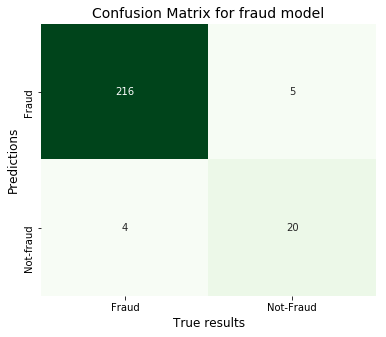

In [122]:
#Confusion matrix
fig, ax = plt.subplots(figsize=(6,5))

sns.heatmap(cm, annot=True,fmt='g',cmap='Greens', cbar=False)# cmap='plt.cm.copper')
ax.set_title("Confusion Matrix for fraud model", fontsize=14)
ax.set_xlabel("True results", fontsize=12)
ax.set_ylabel("Predictions", fontsize=12)
ax.set_xticklabels(['Fraud', 'Not-Fraud'], fontsize=10)#, rotation=90)
ax.set_yticklabels(['Fraud', 'Not-fraud'], fontsize=10)#, rotation=360)

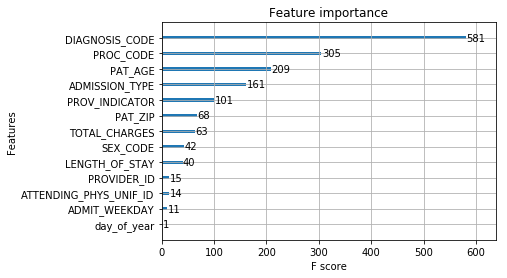

In [35]:
xgb.plot_importance(model_xgb)

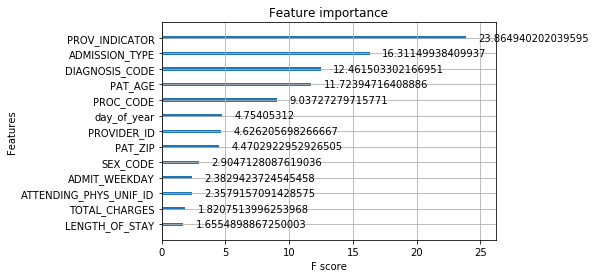

In [36]:
xgb.plot_importance(model_xgb,importance_type = 'gain')

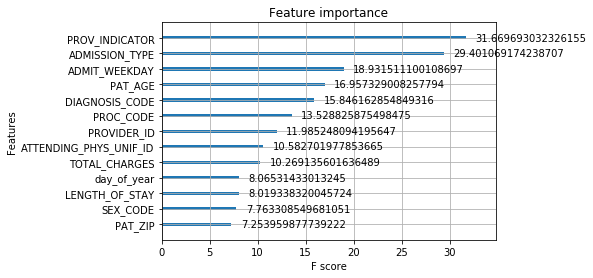

In [284]:
xgb.plot_importance(model_xgb,importance_type = 'cover' )

In [128]:
model_xgb.save_model('healthcare_fraud.model')

In [129]:
bst = xgb.Booster(model_file = 'healthcare_fraud.model')

## Shap

In [130]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(df_x)

In [131]:
shap.force_plot(explainer.expected_value, shap_values[0,:], df_x.iloc[0,:], link = "logit")

## Modeling for fraud type

In [431]:
df.head()

,PROVIDER_ID,PROVIDER_NAME,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,DATE_OF_SERVICE,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,RECORD_ID,Fraud,Fraud Type,day_of_year,month
0,100,0,0,0,0,77859,2012-11-12,2,3,8,1362.0,0,20205,9999999998,1.201020e+11,1,Upcoding,317,11
1,100,0,0,0,0,78753,2012-10-13,7,4,7,1816.0,0,20103,9999999998,1.201020e+11,1,Unbundling,287,10
2,100,0,0,0,1,78751,2012-12-01,7,77,4,34958.0,0,20200,9999999998,1.201020e+11,1,Unbundling,336,12
3,100,0,0,0,0,76543,2012-12-01,7,4,8,1816.0,1,24300,9999999998,1.201020e+11,1,Unbundling,336,12
4,100,0,0,0,0,77378,2012-12-01,7,5,10,2270.0,1,22551,9999999998,1.201020e+11,1,Upcoding,336,12


In [72]:
df_fraudtype = df[df['Fraud']==1].drop(columns = ['Fraud', 'DATE_OF_SERVICE', 'RECORD_ID','PROVIDER_NAME']).copy(deep = True)

In [73]:
df_fraudtype.head()

,PROVIDER_ID,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,Fraud Type,day_of_year,month
0,100,0,0,0,77859,2,3,8,1362.0,0,20205,9999999998,Upcoding,317,11
1,100,0,0,0,78753,7,4,7,1816.0,0,20103,9999999998,Unbundling,287,10
2,100,0,0,1,78751,7,77,4,34958.0,0,20200,9999999998,Unbundling,336,12
3,100,0,0,0,76543,7,4,8,1816.0,1,24300,9999999998,Unbundling,336,12
4,100,0,0,0,77378,7,5,10,2270.0,1,22551,9999999998,Upcoding,336,12


In [74]:
fraud_type_map = {v:i for i,v in enumerate(df_fraudtype['Fraud Type'].unique())}
fraud_type_map_reverse = {i:v for i,v in enumerate(df_fraudtype['Fraud Type'].unique())}


In [75]:
df_fraudtype['Fraud Type'] = df_fraudtype['Fraud Type'].map(fraud_type_map)

In [76]:
fraud_type_map, fraud_type_map_reverse

({'Upcoding': 0,
  'Unbundling': 1,
  'Unnecessary Service': 2,
  'DX does not require Emergancy': 3,
  'DX Does not require Admissions': 4},
 {0: 'Upcoding',
  1: 'Unbundling',
  2: 'Unnecessary Service',
  3: 'DX does not require Emergancy',
  4: 'DX Does not require Admissions'})

In [132]:
with open('fraud_type_map.pk','wb') as f:
    pickle.dump(fraud_type_map,f)
    
with open('fraud_type_map_reverse.pk','wb') as f:
    pickle.dump(fraud_type_map_reverse,f)

In [77]:
df_fraudtype['Fraud Type'].unique(), df_fraudtype['Fraud Type'].nunique()


(array([0, 1, 2, 3, 4], dtype=int64), 5)

In [78]:
df_x = df_fraudtype.drop('Fraud Type', axis = 1)
df_y = df_fraudtype['Fraud Type'].values

X_train, X_test,y_train, y_test = train_test_split(df_x, df_y, test_size = 0.15, random_state = 123) 

train_data = xgb.DMatrix(X_train, label = y_train)
test_data = xgb.DMatrix(X_test, label = y_test)

In [79]:
# sum(df_fraud.Fraud == 1), sum(df_fraud.Fraud == 0), sum(df_fraud.Fraud == 1)/len(df_fraud), sum(df_fraud.Fraud == 0)/sum(df_fraud.Fraud == 1)

In [80]:
# np.mean(df_fraud.Fraud == 1)

In [81]:
# Defining parameters
#scale_pos_weight = sum(df_fraud.Fraud == False)/sum(df_fraud.Fraud == True)
num_class = df_fraudtype['Fraud Type'].nunique()

params = {
    'objective': 'multi:softmax',
    'learning_rate': 0.01,
    'max_depth': 6,
    'silent': 1,
    'subsample': 0.9,
    'eval_metric': ['merror','mlogloss'],
    'colsample_bytee': 0.8,
    'num_class': num_class
    #'scale_pos_weight' : scale_pos_weight
    #'base_score':np.mean(df.Class == 1)
    }

num_round = 100
watchlist = [(test_data, 'eval'), (train_data, 'train')]

In [82]:
%%time
model_xgb_ftype1 = xgb.train(params, train_data, num_boost_round = num_round,
                     evals = watchlist, verbose_eval = 50,
                     early_stopping_rounds = 100,
                     maximize = False)

[0]	eval-merror:0.033019	eval-mlogloss:1.58812	train-merror:0.010833	train-mlogloss:1.58751
Multiple eval metrics have been passed: 'train-mlogloss' will be used for early stopping.

Will train until train-mlogloss hasn't improved in 100 rounds.
[50]	eval-merror:0.033019	eval-mlogloss:0.909021	train-merror:0.0125	train-mlogloss:0.886095
[99]	eval-merror:0.033019	eval-mlogloss:0.583775	train-merror:0.008333	train-mlogloss:0.548658
Wall time: 549 ms


In [133]:
model_xgb_ftype1.save_model('healthcare_fraudtype.model')

In [53]:
y_test[:3]

array([3, 0, 2], dtype=int64)

In [83]:
pred = model_xgb_ftype1.predict(test_data)
accuracy_score(y_test, pred), f1_score(y_test, pred, average = None)

(0.9669811320754716,
 array([0.93023256, 0.96428571, 0.96385542, 1.        , 0.93877551]))

In [86]:
pred_xtrain = model_xgb_ftype1.predict(train_data)
X_train['fraudtype'] = pred_xtrain
X_train.head()

c:\anaconda3\envs\shap\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,PROVIDER_ID,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,day_of_year,month,fraudtype
835,26000,0,3,0,79201,6,2,0,657.0,44,9955,6387432529,192,7,3.0
403,101,0,1,1,79720,6,7,12,4200.0,14,3951,9999999998,192,7,2.0
1418,38001,0,3,0,75951,6,3,7,9894.6,66,736,4169008553,193,7,3.0
894,27000,0,0,1,75051,7,1,12,437.0,28,3812,9999999998,194,7,4.0
309,101,0,1,0,79720,7,38,12,22800.0,7,131,9999999998,194,7,2.0


In [88]:
# X_train['fraudtype'] = 
X_train['fraudtype'].map(fraud_type_map_reverse)

835      DX does not require Emergancy
403                Unnecessary Service
1418     DX does not require Emergancy
894     DX Does not require Admissions
309                Unnecessary Service
1205                        Unbundling
881      DX does not require Emergancy
1393     DX does not require Emergancy
194                Unnecessary Service
120                Unnecessary Service
1323     DX does not require Emergancy
1177                        Unbundling
170                Unnecessary Service
1390     DX does not require Emergancy
1061    DX Does not require Admissions
283                Unnecessary Service
482                Unnecessary Service
1560     DX does not require Emergancy
1213                        Unbundling
1274                          Upcoding
1077    DX Does not require Admissions
1299     DX does not require Emergancy
983                         Unbundling
280                Unnecessary Service
33                 Unnecessary Service
1441     DX does not requ

## Multiclass with output probabilities

In [89]:
# Defining parameters
#scale_pos_weight = sum(df_fraud.Fraud == False)/sum(df_fraud.Fraud == True)
num_class = df_fraudtype['Fraud Type'].nunique()

params = {
    'objective': 'multi:softprob',
    'learning_rate': 0.01,
    'max_depth': 6,
    'silent': 1,
    'subsample': 0.9,
    'eval_metric': ['merror','mlogloss'],
    'colsample_bytee': 0.8,
    'num_class': num_class
    #'scale_pos_weight' : scale_pos_weight
    #'base_score':np.mean(df.Class == 1)
    }

num_round = 100
watchlist = [(test_data, 'eval'), (train_data, 'train')]

In [90]:
%%time
model_xgb_ftype2 = xgb.train(params, train_data, num_boost_round = num_round,
                     evals = watchlist, verbose_eval = 150,
                     early_stopping_rounds = 100,
                     maximize = False)

[0]	eval-merror:0.033019	eval-mlogloss:1.58812	train-merror:0.010833	train-mlogloss:1.58751
Multiple eval metrics have been passed: 'train-mlogloss' will be used for early stopping.

Will train until train-mlogloss hasn't improved in 100 rounds.
[99]	eval-merror:0.033019	eval-mlogloss:0.583775	train-merror:0.008333	train-mlogloss:0.548658
Wall time: 460 ms


In [91]:
fraud_type_probs =model_xgb_ftype2.predict(test_data)
fraud_type_probs[:5]

array([[0.09483849, 0.09452389, 0.09492063, 0.62003267, 0.0956843 ],
       [0.18976642, 0.14191696, 0.3828631 , 0.1417943 , 0.1436592 ],
       [0.17344053, 0.17401162, 0.30865073, 0.17080861, 0.17308849],
       [0.09631358, 0.09599408, 0.09903461, 0.09591111, 0.6127466 ],
       [0.09483849, 0.09452389, 0.09492063, 0.62003267, 0.0956843 ]],
      dtype=float32)

In [92]:
fraud_type_probs.amax(axis = 1)[:4]

AttributeError: 'numpy.ndarray' object has no attribute 'amax'

In [482]:
model_xgb_ftype2.predict(test_data)

(212, 5)

212

## Loadin all models, parameters and testing on test data

In [512]:
model1 = xgb.Booster(model_file = 'healthcare_fraud.model')
model2 = xgb.Booster(model_file = 'healthcare_fraudtype.model')                 

In [513]:
with open('column_map_FAA.pk','rb') as f:
    c_map = pickle.load(f)

fraudtype_map = pickle.load(open('fraud_type_map.pk', 'rb'))
fraudtype_map_reverse = pickle.load(open('fraud_type_map_reverse.pk', 'rb'))

In [538]:
print(c_map)

{'PROV_INDICATOR': {'Facility': 0, 'Ambulatory Care': 1, 'Emergancy Care': 2, 'Professional': 3}, 'ADMISSION_TYPE': {'ELECTIVE ADMISSION': 0, 'NEWBORN': 1, 'URGENT': 2, 'Emergency': 3}, 'SEX_CODE': {'F': 0, 'M': 1}, 'DIAGNOSIS_CODE': {'F952': 0, 'F329': 1, 'F4321': 2, 'F341': 3, 'F42': 4, 'F0630': 5, 'F060': 6, 'F259': 7, 'F29': 8, 'F3160': 9, 'F200': 10, 'F315': 11, 'F319': 12, 'J70': 13, 'F209': 14, 'J68': 15, 'M542': 16, 'H9072': 17, 'J9690': 18, 'S06360A': 19, 'R112': 20, 'I629': 21, 'C719': 22, 'D432': 23, 'D434': 24, 'T85192A': 25, 'C717': 26, 'I6529': 27, 'I498': 28, 'S14105A': 29, 'G309': 30, 'J029': 31, 'J069': 32, 'J189': 33, 'K37': 34, 'I959': 35, 'D121': 36, 'K3589': 37, 'M179': 38, 'K8020': 39, 'R1011': 40, 'H04309': 41, 'V221': 42, 'V3000': 43, 'V3001': 44, 'Q383': 45, 'R531': 46, 'C9100': 47, 'H9071': 48, 'C7931': 49, 'I6350': 50, 'G35': 51, 'R51': 52, 'C801': 53, 'R5383': 54, 'I2699': 55, 'H532': 56, 'J210': 57, 'J45901': 58, 'I509': 59, 'G441': 60, 'C61': 61, 'O471': 6

In [520]:
t = pd.read_csv('HEALTHCARE_FRAUD.CSV')

In [522]:
t.columns

Index(['PROVIDER_ID', 'PROVIDER_NAME', 'PROV_INDICATOR', 'ADMISSION_TYPE',
       'SEX_CODE', 'PAT_ZIP', 'DATE_OF_SERVICE', 'ADMIT_WEEKDAY',
       'LENGTH_OF_STAY', 'PAT_AGE', 'TOTAL_CHARGES', 'DIAGNOSIS_CODE',
       'PROC_CODE', 'ATTENDING_PHYS_UNIF_ID', 'RECORD_ID'],
      dtype='object')

In [515]:
t.to_json('HEALTHCARE_FRAUD.json', orient = 'records')

In [539]:
t = pd.read_json('HEALTHCARE_FRAUD.json', orient = 'records', )

In [540]:
print(t.shape)
col_seq = ['PROVIDER_ID', 'PROVIDER_NAME', 'PROV_INDICATOR', 'ADMISSION_TYPE',
       'SEX_CODE', 'PAT_ZIP', 'DATE_OF_SERVICE', 'ADMIT_WEEKDAY',
       'LENGTH_OF_STAY', 'PAT_AGE', 'TOTAL_CHARGES', 'DIAGNOSIS_CODE',
       'PROC_CODE', 'ATTENDING_PHYS_UNIF_ID', 'RECORD_ID']

(11, 15)


In [541]:
t = t.reindex(columns = col_seq)

In [542]:
t.head()

,PROVIDER_ID,PROVIDER_NAME,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,DATE_OF_SERVICE,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,RECORD_ID
0,1000,Baptist St Anthonys Ambulatory Care,Ambulatory Care,ELECTIVE ADMISSION,M,79118,7/12/2013,6,4,18,"$43,511.88",S06360A,131,9999999998,120102000000
1,38001,CHRISTUS Jasper Memorial Hospital,Facility,Emergency,M,75979,11/12/2012,2,1,0,"$1,456.37",V3000,9955,6163274563,120102000000
2,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,77859,11/12/2012,2,3,8,"$1,362.00",F952,20205,9999999998,120101891753
3,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,78753,10/13/2012,7,4,7,"$1,816.00",F952,20103,9999999998,120101891915
4,26000,Childress Regional Medical Center,Emergancy Care,URGENT,F,79248,7/13/2013,7,3,18,"$5,710.00",M542,1916,9999999998,120102000000


In [543]:
t_output = t.copy(deep = True)

In [544]:
t['DATE_OF_SERVICE'] = pd.to_datetime(t['DATE_OF_SERVICE'])
t['DAY_OF_YEAR'] = t['DATE_OF_SERVICE'].dt.dayofyear
t['MONTH'] = t['DATE_OF_SERVICE'].dt.month
t['TOTAL_CHARGES'] = t['TOTAL_CHARGES'].str.strip().str.slice(start = 1).str.replace(',','').astype(float)
# t['Fraud'] = np.where(t['Fraud']== 'Yes',1,0)

In [532]:
t_fraud = t.drop(columns = ['DATE_OF_SERVICE', 'RECORD_ID','PROVIDER_NAME'])

In [533]:
t_display = t_fraud.copy(deep = True)

In [534]:
for col in c_map.keys():
    t_fraud[col] = t_fraud[col].map(c_map[col])

In [549]:
pred_t = model1.predict(xgb.DMatrix(t_fraud))
pred_t

array([0.7416266 , 0.19941399, 0.787376  , 0.7997581 , 0.8146916 ,
       0.19941399, 0.7024268 , 0.7049872 , 0.7217064 , 0.3901444 ,
       0.35435417], dtype=float32)

In [550]:
model1.feature_names

['PROVIDER_ID',
 'PROV_INDICATOR',
 'ADMISSION_TYPE',
 'SEX_CODE',
 'PAT_ZIP',
 'ADMIT_WEEKDAY',
 'LENGTH_OF_STAY',
 'PAT_AGE',
 'TOTAL_CHARGES',
 'DIAGNOSIS_CODE',
 'PROC_CODE',
 'ATTENDING_PHYS_UNIF_ID',
 'DAY_OF_YEAR',
 'MONTH']

In [551]:
t_output['Fraud'] = np.where(pred_t >= 0.6, 'Yes', 'No')

In [552]:
explainer = shap.TreeExplainer(model1)
shap_values = explainer.shap_values(t_fraud)

In [553]:
shap.force_plot(explainer.expected_value, shap_values[3,:], t_display.iloc[3,:])

In [554]:
shap.force_plot(explainer.expected_value, shap_values[:,:], t_display.iloc[:,:])

In [563]:
t_fraudtype =t_fraud.copy()
t_fraudtype['Fraud'] = np.where(pred_t>=0.6, 1,0)

In [564]:
t_fraudtype

,PROVIDER_ID,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,DAY_OF_YEAR,MONTH,Fraud
0,1000,1,0,1,79118,6,4,18,43511.88,19,131,9999999998,317,11,1
1,38001,0,3,1,75979,2,1,0,1456.37,43,9955,6163274563,287,10,0
2,100,0,0,0,77859,2,3,8,1362.00,0,20205,9999999998,336,12,1
3,100,0,0,0,78753,7,4,7,1816.00,0,20103,9999999998,336,12,1
4,26000,2,2,0,79248,7,3,18,5710.00,16,1916,9999999998,336,12,1
5,26000,0,3,1,79252,6,2,0,549.00,43,20311,1195629471,336,12,0
6,27000,0,0,1,75040,6,4,15,35083.69,47,3821,4141418103,336,12,1
7,31001,3,0,1,75644,6,9,20,15671.25,56,3893,9999999998,336,12,1
8,31001,3,0,1,75684,6,5,19,11578.40,52,4311,9999999998,336,12,1
9,101,0,1,1,75693,6,31,8,18600.00,7,139,9999999998,336,12,0


In [565]:
t_fraudtype_pred = t_fraudtype[t_fraudtype['Fraud']==1].copy()
t_fraudtype_pred.drop(columns = 'Fraud',inplace = True)
t_fraudtype_pred

,PROVIDER_ID,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,DAY_OF_YEAR,MONTH
0,1000,1,0,1,79118,6,4,18,43511.88,19,131,9999999998,317,11
2,100,0,0,0,77859,2,3,8,1362.00,0,20205,9999999998,336,12
3,100,0,0,0,78753,7,4,7,1816.00,0,20103,9999999998,336,12
4,26000,2,2,0,79248,7,3,18,5710.00,16,1916,9999999998,336,12
6,27000,0,0,1,75040,6,4,15,35083.69,47,3821,4141418103,336,12
7,31001,3,0,1,75644,6,9,20,15671.25,56,3893,9999999998,336,12
8,31001,3,0,1,75684,6,5,19,11578.40,52,4311,9999999998,336,12


In [353]:
t_fraudtype[]
predtype_t = model2.predict(xgb.DMatrix(t_fraudtype_pred))
predtype_t

array([2., 1., 1., 0., 4., 2., 2.], dtype=float32)

In [537]:
print(fraudtype_map_reverse)

{0: 'Upcoding', 1: 'Unbundling', 2: 'Unnecessary Service', 3: 'DX does not require Emergancy', 4: 'DX Does not require Admissions'}


In [354]:
t_fraudtype_pred['FraudType'] = predtype_t

In [356]:
# t_output['FraudType'] = 
t_fraudtype_pred['FraudType'] = t_fraudtype_pred['FraudType'].map(fraudtype_map_reverse)

In [357]:
t_fraudtype_pred

,PROVIDER_ID,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,DAY_OF_YEAR,MONTH,FraudType
0,1000,1,0,1,79118,6,4,18,43511.88,19,131,9999999998,317,11,Unnecessary Service
2,100,0,0,0,77859,2,3,8,1362.00,0,20205,9999999998,336,12,Unbundling
3,100,0,0,0,78753,7,4,7,1816.00,0,20103,9999999998,336,12,Unbundling
4,26000,2,2,0,79248,7,3,18,5710.00,16,1916,9999999998,336,12,Upcoding
6,27000,0,0,1,75040,6,4,15,35083.69,47,3821,4141418103,336,12,DX Does not require Admissions
7,31001,3,0,1,75644,6,9,20,15671.25,56,3893,9999999998,336,12,Unnecessary Service
8,31001,3,0,1,75684,6,5,19,11578.40,52,4311,9999999998,336,12,Unnecessary Service


In [388]:
t_fraudtype = t_fraudtype.merge(t_fraudtype_pred, how ='left')

In [394]:
t_output['FraudType'] = t_fraudtype['FraudType'].fillna('N.A.')

In [395]:
t_output

,PROVIDER_ID,PROVIDER_NAME,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,DATE_OF_SERVICE,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,RECORD_ID,Fraud,FraudType
0,1000,Baptist St Anthonys Ambulatory Care,Ambulatory Care,ELECTIVE ADMISSION,M,79118,7/12/2013,6,4,18,"$43,511.88",S06360A,131,9999999998,1.201020e+11,Yes,Unnecessary Service
1,38001,CHRISTUS Jasper Memorial Hospital,Facility,Emergency,M,75979,11/12/2012,2,1,0,"$1,456.37",V3000,9955,6163274563,1.201020e+11,No,N.A.
2,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,77859,11/12/2012,2,3,8,"$1,362.00",F952,20205,9999999998,1.201019e+11,Yes,Unbundling
3,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,78753,10/13/2012,7,4,7,"$1,816.00",F952,20103,9999999998,1.201019e+11,Yes,Unbundling
4,26000,Childress Regional Medical Center,Emergancy Care,URGENT,F,79248,7/13/2013,7,3,18,"$5,710.00",M542,1916,9999999998,1.201020e+11,Yes,Upcoding
5,26000,Childress Regional Medical Center,Facility,Emergency,M,79252,7/11/2014,6,2,0,$549.00,V3000,20311,1195629471,1.201020e+11,No,N.A.
6,27000,Baylor Medical Center-Garland,Facility,ELECTIVE ADMISSION,M,75040,7/12/2013,6,4,15,"$35,083.69",C9100,3821,4141418103,1.201020e+11,Yes,DX Does not require Admissions
7,31001,Allegiance Specialty Clinics,Professional,ELECTIVE ADMISSION,M,75644,7/12/2013,6,9,20,"$15,671.25",H532,3893,9999999998,1.201020e+11,Yes,Unnecessary Service
8,31001,Allegiance Specialty Clinics,Professional,ELECTIVE ADMISSION,M,75684,7/11/2014,6,5,19,"$11,578.40",R51,4311,9999999998,1.201020e+11,Yes,Unnecessary Service
9,101,Big Spring State Hospital,Facility,NEWBORN,M,75693,7/11/2014,6,31,8,"$18,600.00",F259,139,9999999998,1.201020e+11,No,N.A.


## API test

In [570]:
## Example how to access the API for Fast Track claims settlement which receives and returns JSON output.
## There are three keys in the output: 
## 1."predictions" which contain the data along with predictio in json format, 
## 2. and "plots" which contain the shap plot for each prediction row
## 3. and "combined" which contain the combined shap plot


import requests
import json
import pandas as pd

header = {'Content-Type': 'application/json', \
                  'Accept': 'application/json'}
                  
#Read json file
with open('HEALTHCARE_FRAUD.json', 'rt') as f:
    data = json.load(f)

#Send request to server. Change localhost to server where API is hosted
resp2 = requests.post("http://localhost:5000/predict", \
                   data = json.dumps(data),\
                   headers= header)

#Return Status:  200
print("Return Status: ",resp2.status_code)

preds2 = resp2.json()

# Contains the each row and the prediction
print(preds2['predictions'])

# Contains the plots which should appear for each prediction row    
print(preds2['plots'])

# Contains the plots which should appear for each prediction row    
print(preds2['combined'])

Return Status:  200
[{"PROVIDER_ID":1000,"PROVIDER_NAME":"Baptist St Anthonys Ambulatory Care","PROV_INDICATOR":"Ambulatory Care","ADMISSION_TYPE":"ELECTIVE ADMISSION","SEX_CODE":"M","PAT_ZIP":79118,"DATE_OF_SERVICE":"7\/12\/2013","ADMIT_WEEKDAY":6,"LENGTH_OF_STAY":4,"PAT_AGE":18,"TOTAL_CHARGES":"$43,511.88 ","DIAGNOSIS_CODE":"S06360A","PROC_CODE":131,"ATTENDING_PHYS_UNIF_ID":9999999998,"RECORD_ID":120102000000,"Fraud":"Yes","FraudType":"Unnecessary Service"},{"PROVIDER_ID":38001,"PROVIDER_NAME":"CHRISTUS Jasper Memorial Hospital","PROV_INDICATOR":"Facility","ADMISSION_TYPE":"Emergency","SEX_CODE":"M","PAT_ZIP":75979,"DATE_OF_SERVICE":"11\/12\/2012","ADMIT_WEEKDAY":2,"LENGTH_OF_STAY":1,"PAT_AGE":0,"TOTAL_CHARGES":"$1,456.37 ","DIAGNOSIS_CODE":"V3000","PROC_CODE":9955,"ATTENDING_PHYS_UNIF_ID":6163274563,"RECORD_ID":120102000000,"Fraud":"No","FraudType":"N.A."},{"PROVIDER_ID":100,"PROVIDER_NAME":"Austin State Hospital","PROV_INDICATOR":"Facility","ADMISSION_TYPE":"ELECTIVE ADMISSION","SE

{"combined": "<div id='i1HUQNV0XFFJC9SNQD08Y'><div style='color: #900; text-align: center;'>  <b>Visualization omitted, Javascript library not loaded!</b><br>  Have you run `initjs()` in this notebook? If this notebook was from another  user you must also trust this notebook (File -> Trust notebook). If you are viewing  this notebook on github the Javascript has been stripped for security. If you are using  JupyterLab this error is because a JupyterLab extension has not yet been written.</div></div> <script>   if (window.SHAP) SHAP.ReactDom.render(    SHAP.React.createElement(SHAP.AdditiveForceArrayVisualizer, {\"outNames\": [\"output value\"], \"baseValue\": 1.0110560655593872, \"link\": \"identity\", \"featureNames\": [\"PROVIDER_ID\", \"PROV_INDICATOR\", \"ADMISSION_TYPE\", \"SEX_CODE\", \"PAT_ZIP\", \"ADMIT_WEEKDAY\", \"LENGTH_OF_STAY\", \"PAT_AGE\", \"TOTAL_CHARGES\", \"DIAGNOSIS_CODE\", \"PROC_CODE\", \"ATTENDING_PHYS_UNIF_ID\", \"DAY_OF_YEAR\", \"MONTH\"], \"explanations\": [{\"

In [586]:
p = json.loads(preds2['predictions'])
p[2]
p_df = pd.read_json(preds2['predictions'])
p_df = p_df.reindex(columns = col_seq +['Fraud','FraudType'])
p_df

,PROVIDER_ID,PROVIDER_NAME,PROV_INDICATOR,ADMISSION_TYPE,SEX_CODE,PAT_ZIP,DATE_OF_SERVICE,ADMIT_WEEKDAY,LENGTH_OF_STAY,PAT_AGE,TOTAL_CHARGES,DIAGNOSIS_CODE,PROC_CODE,ATTENDING_PHYS_UNIF_ID,RECORD_ID,Fraud,FraudType,Fraud,FraudType
0,1000,Baptist St Anthonys Ambulatory Care,Ambulatory Care,ELECTIVE ADMISSION,M,79118,7/12/2013,6,4,18,"$43,511.88",S06360A,131,9999999998,120102000000,Yes,Unnecessary Service,Yes,Unnecessary Service
1,38001,CHRISTUS Jasper Memorial Hospital,Facility,Emergency,M,75979,11/12/2012,2,1,0,"$1,456.37",V3000,9955,6163274563,120102000000,No,N.A.,No,N.A.
2,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,77859,11/12/2012,2,3,8,"$1,362.00",F952,20205,9999999998,120101891753,Yes,Unbundling,Yes,Unbundling
3,100,Austin State Hospital,Facility,ELECTIVE ADMISSION,F,78753,10/13/2012,7,4,7,"$1,816.00",F952,20103,9999999998,120101891915,Yes,Unbundling,Yes,Unbundling
4,26000,Childress Regional Medical Center,Emergancy Care,URGENT,F,79248,7/13/2013,7,3,18,"$5,710.00",M542,1916,9999999998,120102000000,Yes,Upcoding,Yes,Upcoding
5,26000,Childress Regional Medical Center,Facility,Emergency,M,79252,7/11/2014,6,2,0,$549.00,V3000,20311,1195629471,120102000000,No,N.A.,No,N.A.
6,27000,Baylor Medical Center-Garland,Facility,ELECTIVE ADMISSION,M,75040,7/12/2013,6,4,15,"$35,083.69",C9100,3821,4141418103,120102000000,Yes,DX Does not require Admissions,Yes,DX Does not require Admissions
7,31001,Allegiance Specialty Clinics,Professional,ELECTIVE ADMISSION,M,75644,7/12/2013,6,9,20,"$15,671.25",H532,3893,9999999998,120102000000,Yes,Unnecessary Service,Yes,Unnecessary Service
8,31001,Allegiance Specialty Clinics,Professional,ELECTIVE ADMISSION,M,75684,7/11/2014,6,5,19,"$11,578.40",R51,4311,9999999998,120102000000,Yes,Unnecessary Service,Yes,Unnecessary Service
9,101,Big Spring State Hospital,Facility,NEWBORN,M,75693,7/11/2014,6,31,8,"$18,600.00",F259,139,9999999998,120102000000,No,N.A.,No,N.A.


In [587]:
from IPython.core.display import HTML
pl = json.loads(preds2['plots'])
HTML(pl[2]['plots'])

In [588]:
c = json.loads(preds2['combined'])
c['combined']
HTML(c['combined'])